# Bike Sharing Predection using Linear Regression

#### Problem Statement:

US bike-sharing provider BoomBikes in which bikes are made available for shared use to individuals on a short term basis for a price or free. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.

Essentially, the company wants —

- To identify variables which affect demand of shared bike

- To create a linear model that quantitatively relates demand of shared bikes with variables such as number of temperature, season etc.

- To know the accuracy of the model, i.e. how well these variables can predict demand of shared bikes.

In [266]:
# Importing libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

In [267]:
# importing libraries specific to Lienar regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Steps to be followed
- Step 1: Reading and Understanding the Data
- Step 2: Visualising the Data
- Step 3: Data Preparation
- Step 4: Splitting the Data into Training and Testing Sets
- Step 5: Building a linear model
- Step 6: Residual Analysis of the train data
- Step 7: Making Predictions Using the Final Model
- Step 8: Model Evaluation

## Step 1: Reading and Understanding the Data

In [268]:
bike_data = pd.read_csv('./day.csv')
bike_data.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [269]:
# shape of data
bike_data.shape

(730, 16)

In [270]:
# available features
bike_data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [271]:
# Looking at data type and checking for null-values
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


##### Observation
- All features are having non-null values

## Step 2: Visualising the Data

In [272]:
# Defining function for displaying data in table
def data_display_in_table (df):
    x = PrettyTable()
    x.field_names= df.columns
    for index,row in df.iterrows():
        x.add_row(row)
    return x

# Defining function for percentage distribution of categorical variable
def percent_dist_cat_var(categorical_var):
    d1 = pd.DataFrame(bike_data.groupby(categorical_var)['instant'].nunique())
    d2 = round((d1/d1[d1.columns].sum())*100,2)
    d2.reset_index(inplace=True)
    d2.rename(columns={'instant':'percentage'}, inplace=True)
    plt.figure(figsize=(20,5))
    sns.barplot(data=d2,x=categorical_var,y='percentage')
    plt.show()
    print(data_display_in_table(d2))

#### Cheking for duplicate rows

In [273]:
# Finding duplicate rows based on tempreture & humidity
# tempreture & humidity are taken initially, we could have taken any other features as well)
duplicate_rows = bike_data[bike_data.duplicated(['temp','hum'])]
duplicate_rows.shape

(0, 16)

##### Observation
- No duplicate data found

### Derived Metrics
- Separating day from  `dteday` and drop `dteday`, we will keep day as categorical for looking for any patterns for dates

In [274]:
bike_data['day'] = bike_data.dteday.apply(lambda x : int(x[:2]))
bike_data = bike_data.drop('dteday',axis=1)

#### Defining categorical and continous features for plotting 


In [275]:
categorical_vars = ['season','day','mnth','yr','holiday','weekday','workingday','weathersit']
numerical_vars = list(bike_data.columns[~bike_data.columns.isin(categorical_vars)])

# Being not much useful, 'instant' variable is to be removed, and remove 'dteday' as we will deal it separately
numerical_vars = [elem for elem in numerical_vars if elem not in ('instant', 'dteday')]
print(categorical_vars)
print(numerical_vars)

['season', 'day', 'mnth', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit']
['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


In [276]:
# set seaborn styles
sns.set_theme('poster') #for bigger fonts
sns.set_palette('husl')
sns.set_style('whitegrid')

## Outliers Treatment

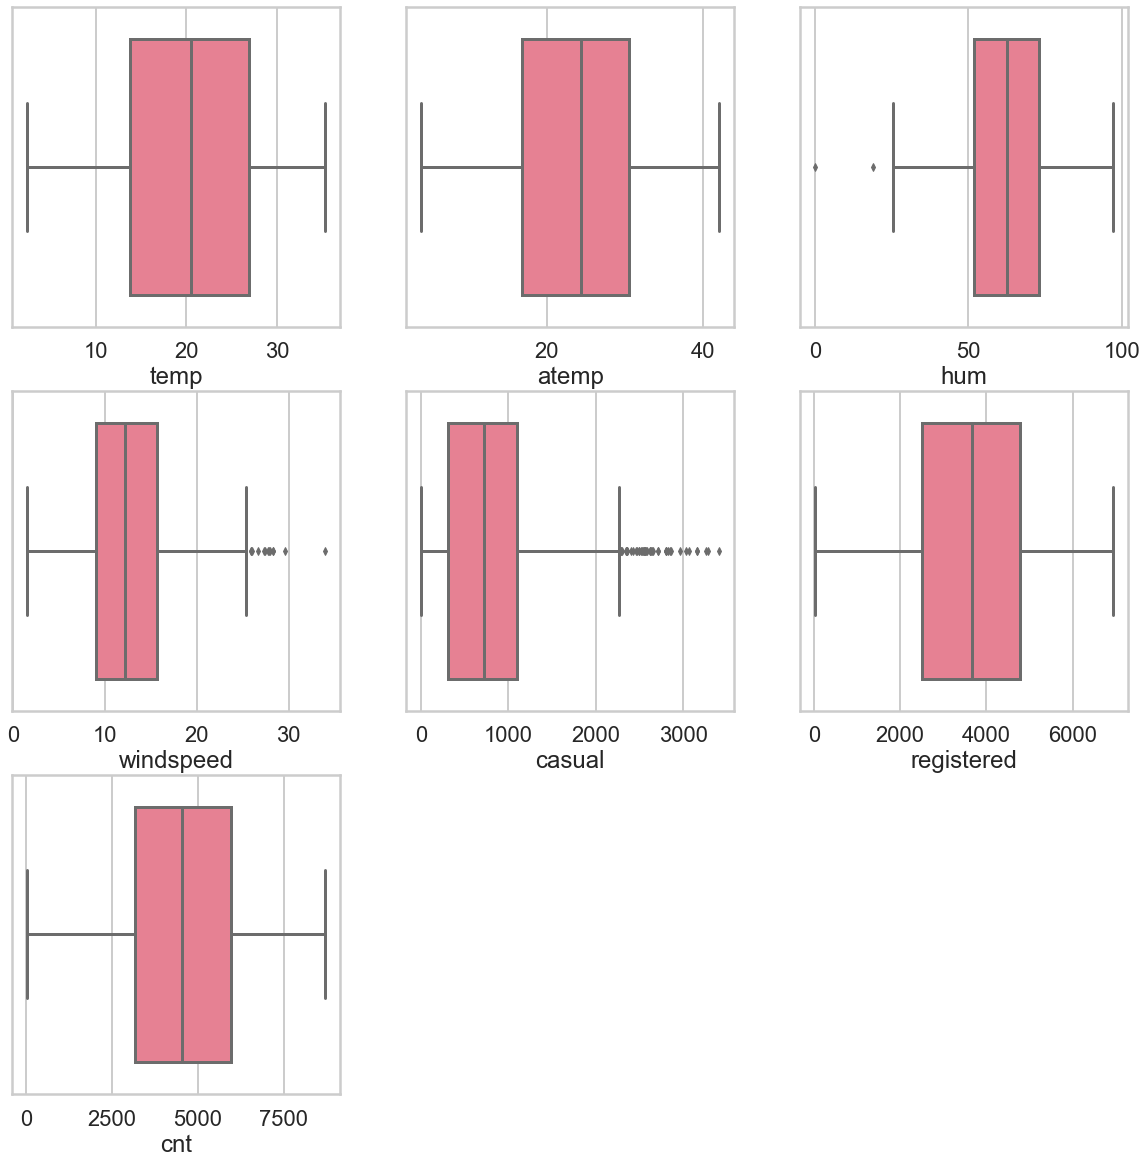

In [277]:
j=1
plt.figure(figsize=(20,20))
for i in numerical_vars:
    plt.subplot(3,3,j)
    sns.boxplot(bike_data[i])
    j+=1
plt.show()

##### Observation
- Windspeed, humidity and casual count of rental bikes are having outliers

Let's set them to lower/upper bound with IQR approach

#### Step 1: Finding Upper and Lower bound for removing outliers

In [278]:
upper_lower_bound_obj = {}
for i in numerical_vars:
    q1 = np.quantile(bike_data[i],0.25)
    q3 = np.quantile(bike_data[i],0.75)
    iqr = q3-q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)
    if lower_bound < 0 :
        lower_bound = np.min(bike_data[i])
    if upper_bound < 0 :
        upper_bound = np.min(bike_data[i])
    upper_lower_bound_obj[i] = {'lower_bound': lower_bound, 'upper_bound':upper_bound}
upper_lower_bound_obj

{'temp': {'lower_bound': 2.4243464, 'upper_bound': 46.483709},
 'atemp': {'lower_bound': 3.95348, 'upper_bound': 50.77986874999999},
 'hum': {'lower_bound': 20.515637499999997, 'upper_bound': 104.4739375},
 'windspeed': {'lower_bound': 1.5002439, 'upper_bound': 25.501498125},
 'casual': {'lower_bound': 2, 'upper_bound': 2266.875},
 'registered': {'lower_bound': 20, 'upper_bound': 8204.75},
 'cnt': {'lower_bound': 22, 'upper_bound': 10160.375}}

#### Step 2: Replacing outliers with lower/upper bound

In [279]:
for i in numerical_vars:
    bike_data.loc[bike_data[i] > upper_lower_bound_obj[i]['upper_bound'],i] = upper_lower_bound_obj[i]['upper_bound']
    bike_data.loc[bike_data[i] < upper_lower_bound_obj[i]['lower_bound'],i] = upper_lower_bound_obj[i]['lower_bound']

#### Looking at continous features afrer outlier treatment

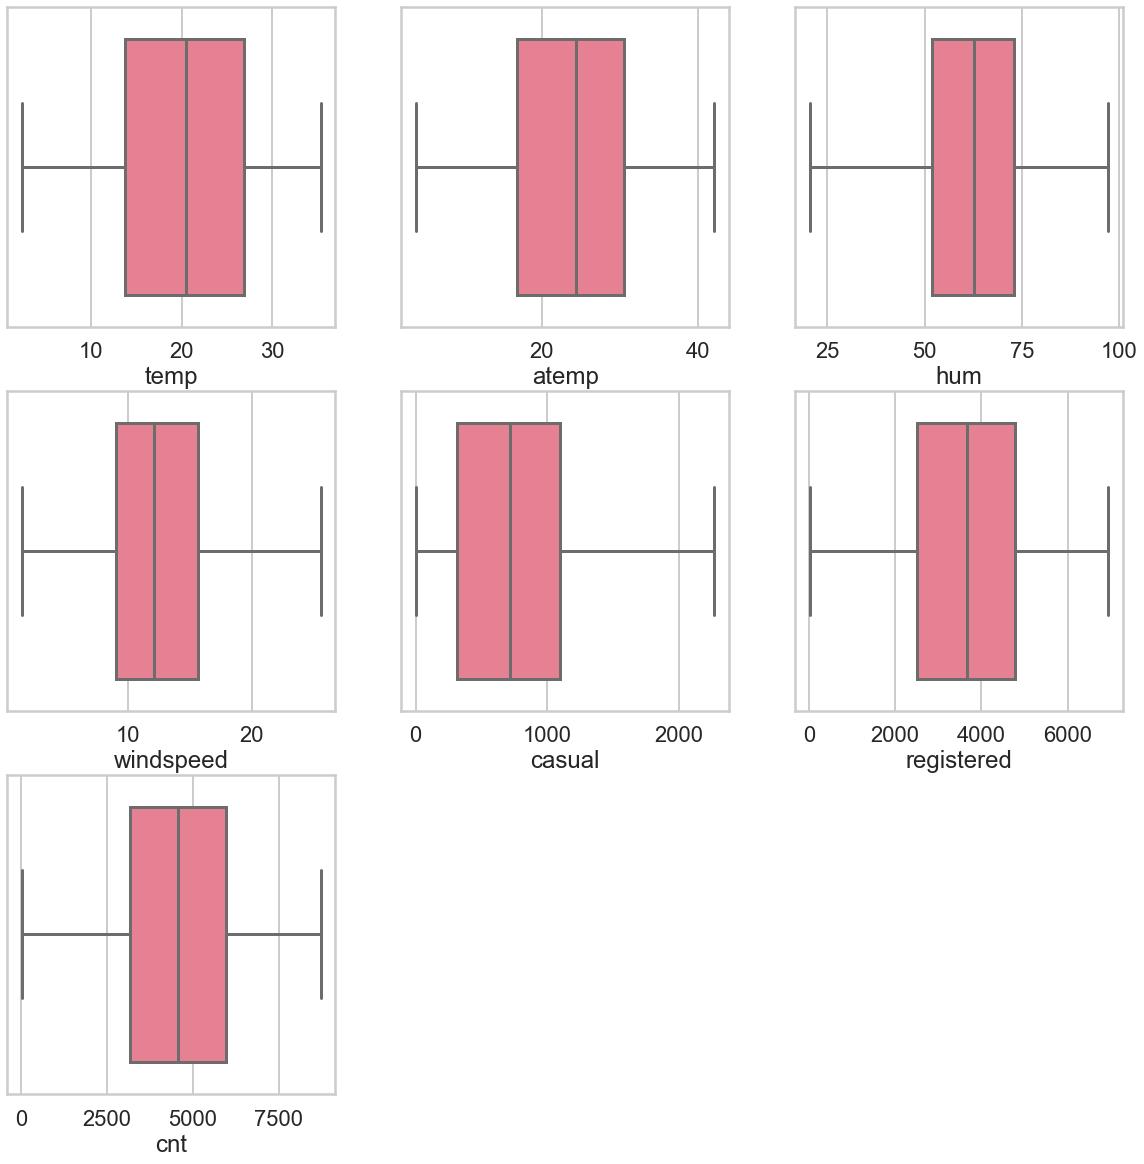

In [280]:
j=1
plt.figure(figsize=(20,20))
for i in numerical_vars:
    plt.subplot(3,3,j)
    sns.boxplot(bike_data[i], palette='husl')
    j+=1
plt.show()

##### Observation
-  Outliers replaced for Windspeed, humidity and casual count of rental bikes

## Univariate analysis

### Continous variables

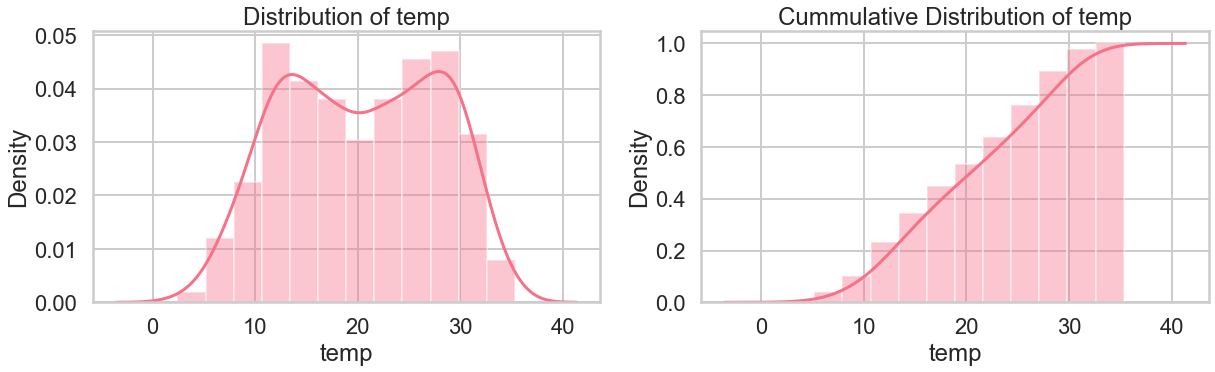

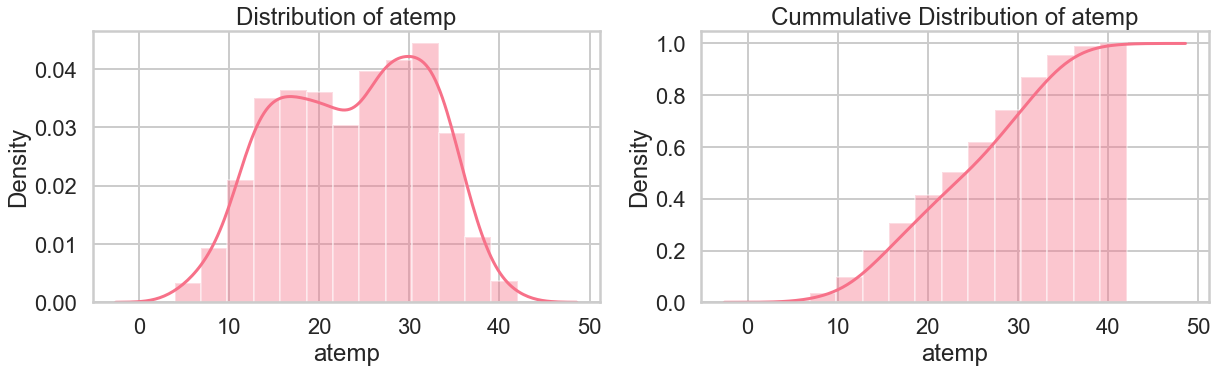

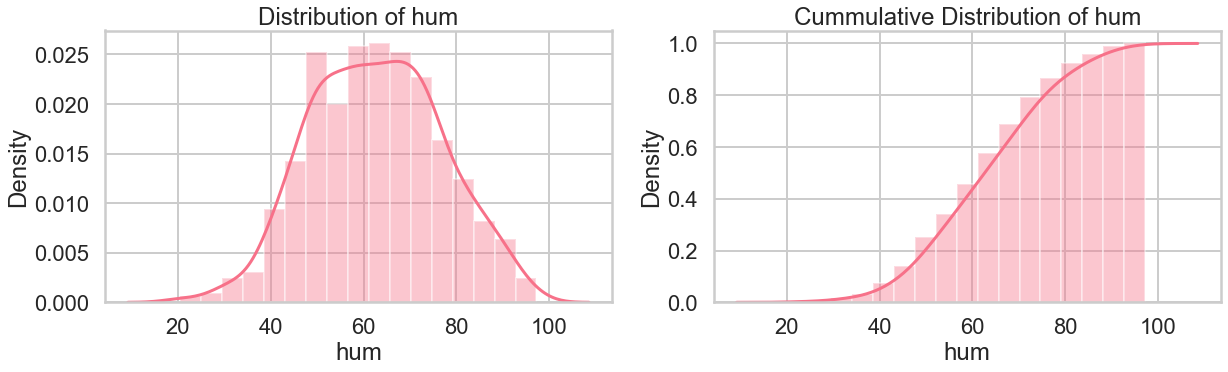

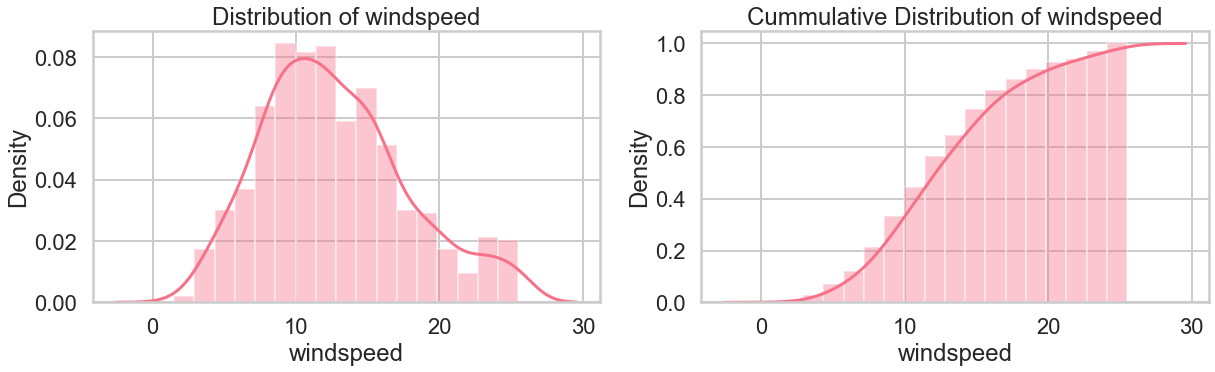

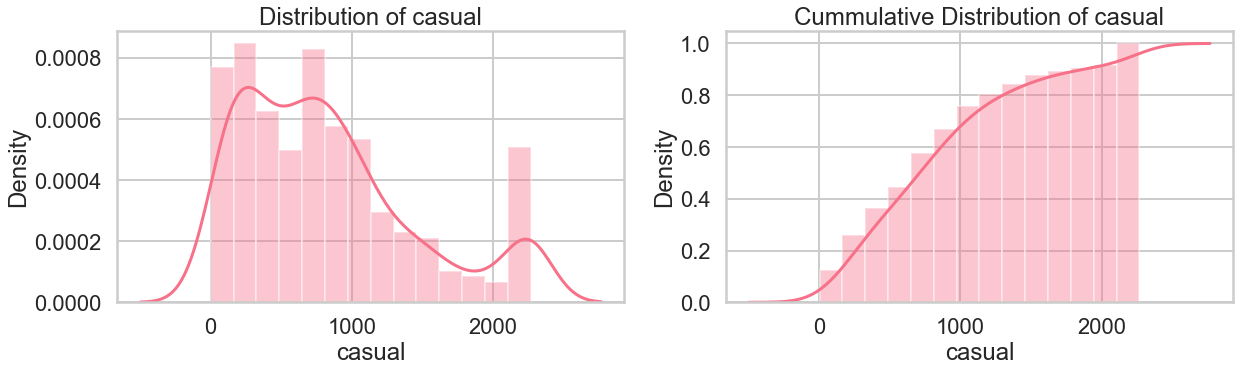

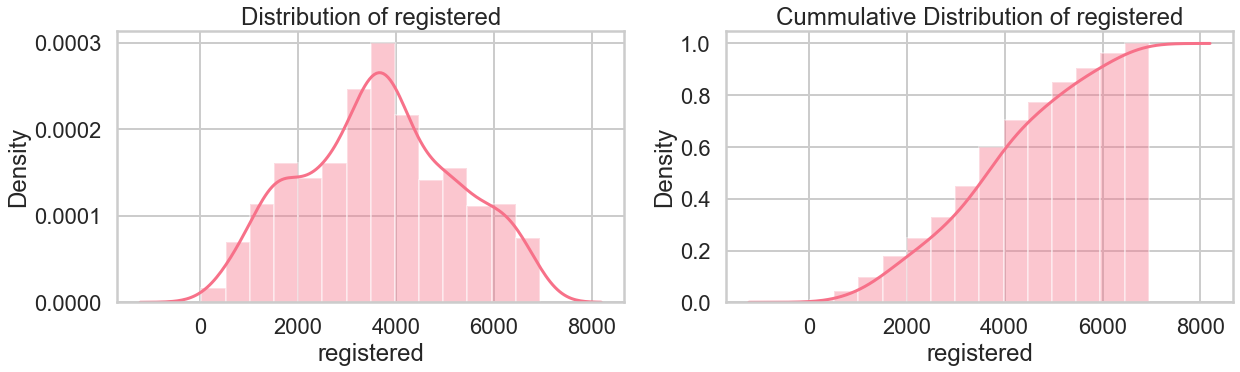

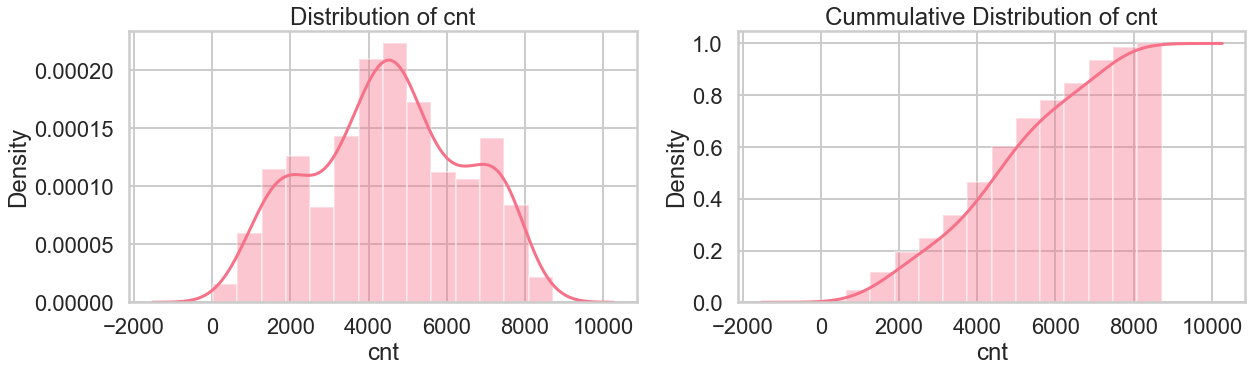

In [281]:
# First take numerical/continous features - Histogram and CDF
for i in numerical_vars:
    fig,ax = plt.subplots(1,2, figsize=(20,5))
    sns.distplot(bike_data[i],ax=ax[0])
    ax[0].set_title('Distribution of {}'.format(i))
    
    kwargs ={'cumulative':True}
    sns.distplot(bike_data[i],ax=ax[1],hist_kws=kwargs, kde_kws=kwargs)
    ax[1].set_title('Cummulative Distribution of {}'.format(i))
plt.show()

##### Observation
- Approx normal distribution: - Count of total rental bikes and registered
- Skewed normal distribution: - Count of casual rental bikes , windspeed, humidity

### Pecentile analysis for numeric variables

#### 1. For temperature

In [282]:
for j in range(0,101,10):
    print('{}th percentile:{}'.format(j,np.percentile(bike_data['temp'],j).round(2)))

0th percentile:2.42
10th percentile:10.65
20th percentile:12.94
30th percentile:14.99
40th percentile:17.55
50th percentile:20.47
60th percentile:23.08
70th percentile:25.9
80th percentile:28.13
90th percentile:30.0
100th percentile:35.33


In [283]:
for j in range(91,100,1):
    print('{}th percentile:{}'.format(j,np.percentile(bike_data['temp'],j).round(2)))

91th percentile:30.32
92th percentile:30.61
93th percentile:30.85
94th percentile:31.31
95th percentile:31.52
96th percentile:31.8
97th percentile:32.05
98th percentile:33.0
99th percentile:33.87


##### Observation
-  90% of temperature is below 30 deg celcious

#### 2. For Feeling temperaute

In [284]:
for j in range(0,101,10):
    print('{}th percentile:{}'.format(j,np.percentile(bike_data['atemp'],j).round(2)))

0th percentile:3.95
10th percentile:12.75
20th percentile:15.55
30th percentile:18.2
40th percentile:21.27
50th percentile:24.37
60th percentile:26.98
70th percentile:29.41
80th percentile:31.88
90th percentile:33.91
100th percentile:42.04


In [285]:
for j in range(91,100,1):
    print('{}th percentile:{}'.format(j,np.percentile(bike_data['atemp'],j).round(2)))

91th percentile:34.36
92th percentile:34.67
93th percentile:35.1
94th percentile:35.28
95th percentile:35.75
96th percentile:36.21
97th percentile:36.63
98th percentile:37.44
99th percentile:38.94


##### Observation
-  90% of feeling temperature is below 33.91 deg celcious

#### 3. For humidity

In [286]:
for j in range(0,101,10):
    print('{}th percentile:{}'.format(j,np.percentile(bike_data['hum'],j).round(2)))

0th percentile:20.52
10th percentile:45.0
20th percentile:49.98
30th percentile:54.18
40th percentile:58.51
50th percentile:62.62
60th percentile:66.88
70th percentile:70.75
80th percentile:75.29
90th percentile:81.76
100th percentile:97.25


In [287]:
for j in range(91,100,1):
    print('{}th percentile:{}'.format(j,np.percentile(bike_data['hum'],j).round(2)))

91th percentile:82.81
92th percentile:83.54
93th percentile:84.41
94th percentile:85.77
95th percentile:86.87
96th percentile:88.12
97th percentile:89.54
98th percentile:90.83
99th percentile:92.8


##### Observation
-  90% of humidity is below 81.76%

#### 4. For Wind speed

In [288]:
for j in range(0,101,10):
    print('{}th percentile:{}'.format(j,np.percentile(bike_data['windspeed'],j).round(2)))

0th percentile:1.5
10th percentile:6.7
20th percentile:8.39
30th percentile:9.58
40th percentile:10.94
50th percentile:12.13
60th percentile:13.43
70th percentile:14.97
80th percentile:16.64
90th percentile:19.83
100th percentile:25.5


In [289]:
for j in range(91,100,1):
    print('{}th percentile:{}'.format(j,np.percentile(bike_data['windspeed'],j).round(2)))

91th percentile:20.35
92th percentile:20.63
93th percentile:21.5
94th percentile:22.44
95th percentile:23.0
96th percentile:23.3
97th percentile:24.0
98th percentile:25.2
99th percentile:25.5


##### Observation
-  90% of wind speed is below 19.83

### Bivariate analysis

### Relation betwn `cnt` and `season`

<AxesSubplot:xlabel='season', ylabel='cnt'>

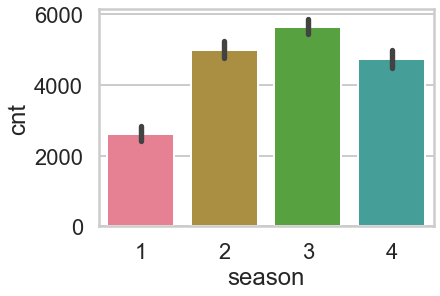

In [290]:
sns.barplot(data=bike_data,x='season',y='cnt')

##### Observation
- Bike demand increases as season goes from 'spring' to 'summer' to 'fall'

### Relation betwn `cnt` and `day`

<AxesSubplot:xlabel='day', ylabel='cnt'>

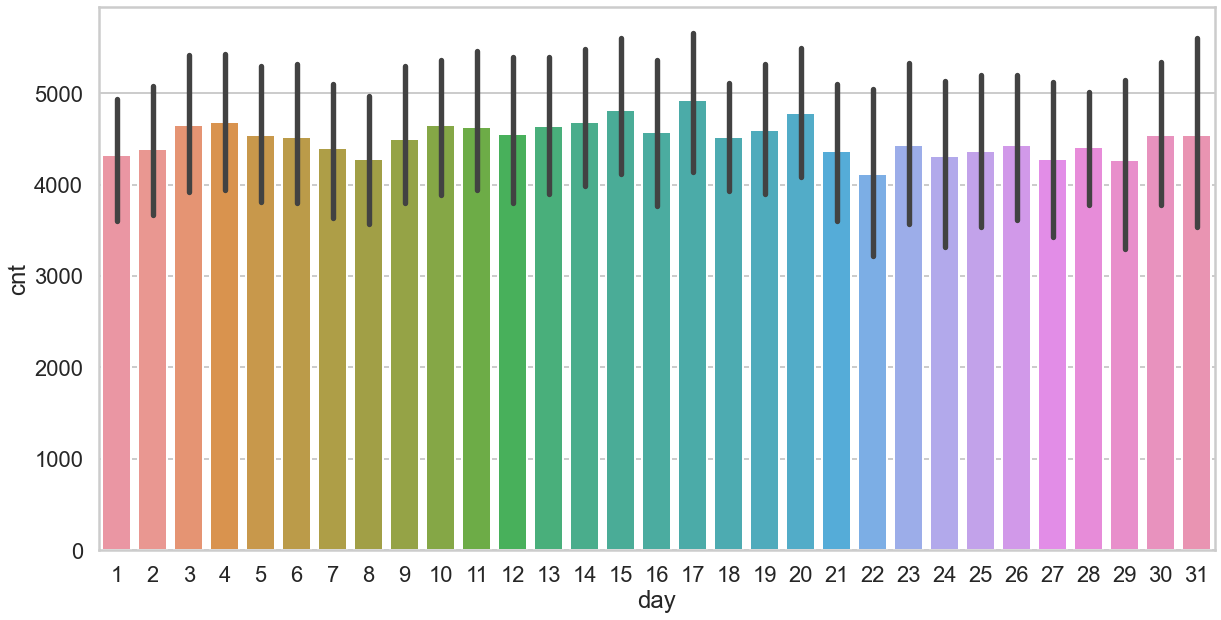

In [291]:
plt.figure(figsize=(20,10))
sns.barplot(data=bike_data,x='day',y='cnt')

##### Observation
- Bike demand is almost same for all days

### Relation betwn `cnt` and `mnth`

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

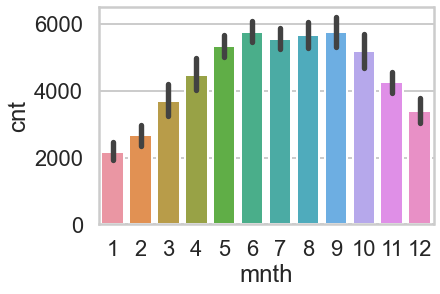

In [292]:
sns.barplot(data=bike_data,x='mnth',y='cnt')

##### Observation
- Bike demand is high in May to October
- Bike demand increases upto september and then decreases

### Relation betwn `cnt` and `yr`

<AxesSubplot:xlabel='yr', ylabel='cnt'>

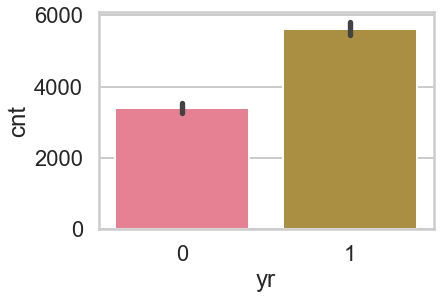

In [293]:
sns.barplot(data=bike_data,x='yr',y='cnt')

##### Observation
- Bike demand is high in 2019, Bike demand increases as time gets passed

### Relation betwn `cnt` and `weathersit`

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

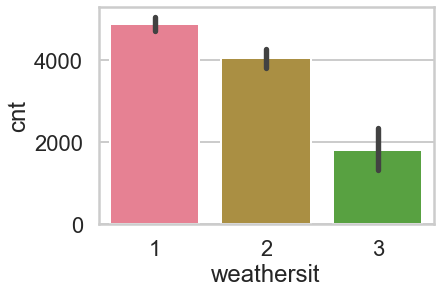

In [294]:
sns.barplot(data=bike_data,x='weathersit',y='cnt')

##### Observation
- Bike demand is highest in good weather(clear sky, few clouds)
- Bike demand decreases as weather gets unpleasant

### Relation betwn `cnt` and `weekday`

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

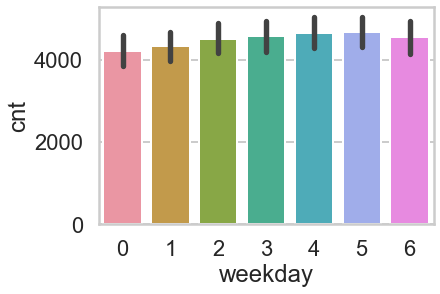

In [295]:
sns.barplot(data=bike_data,x='weekday',y='cnt')

##### Observation
- Bike demand is slightly increases as weekday increases

### Relation betwn `cnt` and `workingday`

<AxesSubplot:xlabel='workingday', ylabel='cnt'>

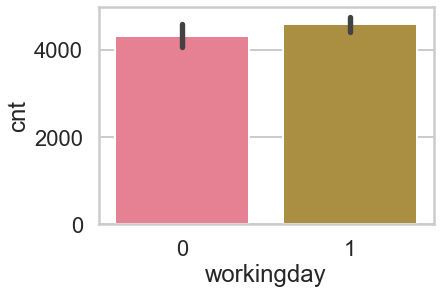

In [296]:
sns.barplot(data=bike_data,x='workingday',y='cnt')

##### Observation
- Bike demand is slightly higher in workingday

### Relation betwn `cnt` and `holiday`

<AxesSubplot:xlabel='holiday', ylabel='cnt'>

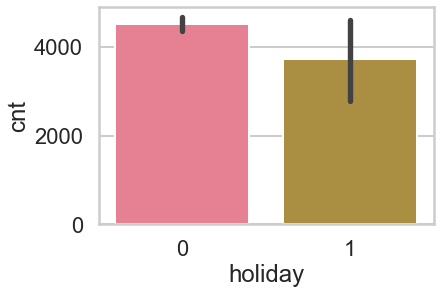

In [297]:
sns.barplot(data=bike_data,x='holiday',y='cnt')

##### Observation
- Bike demand is lower in holiday

### Pair plot for all continous variables

<Figure size 7200x720 with 0 Axes>

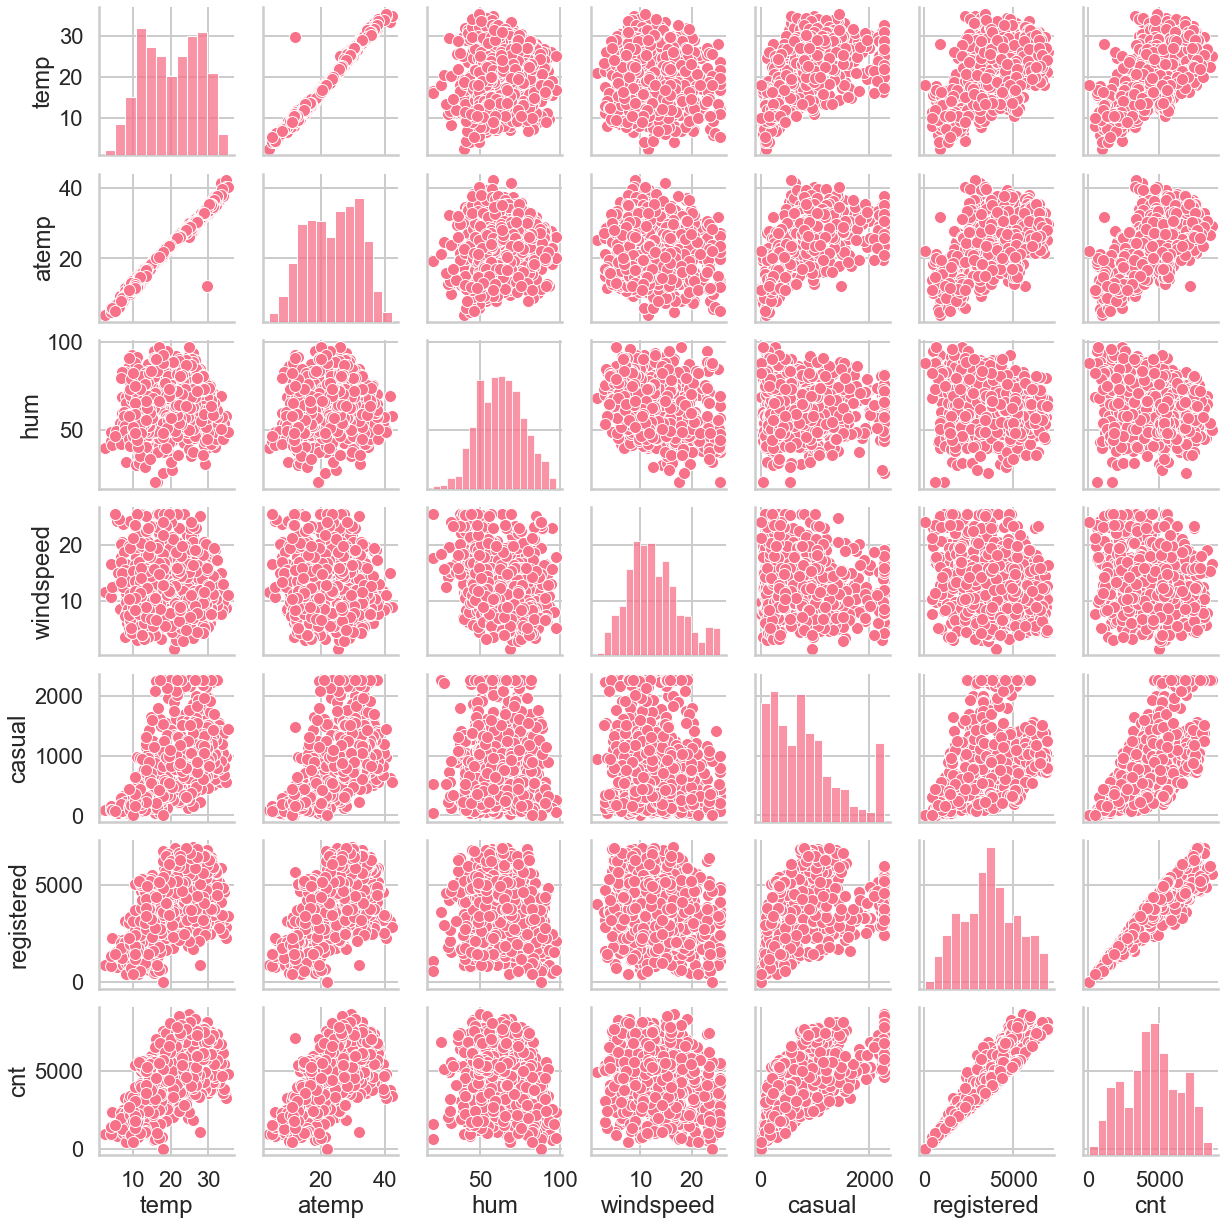

In [298]:
plt.figure(figsize=(100,10))
sns.pairplot(bike_data[numerical_vars])

##### Observation
- Bike demand increases as `atemp`(feeling temperature) rises (and also increases with `temp` but `atemp` reflects `temp` as well)

## Multi variate analysis

### Relation of `cnt` with `atemp` and `season`

<AxesSubplot:xlabel='atemp', ylabel='cnt'>

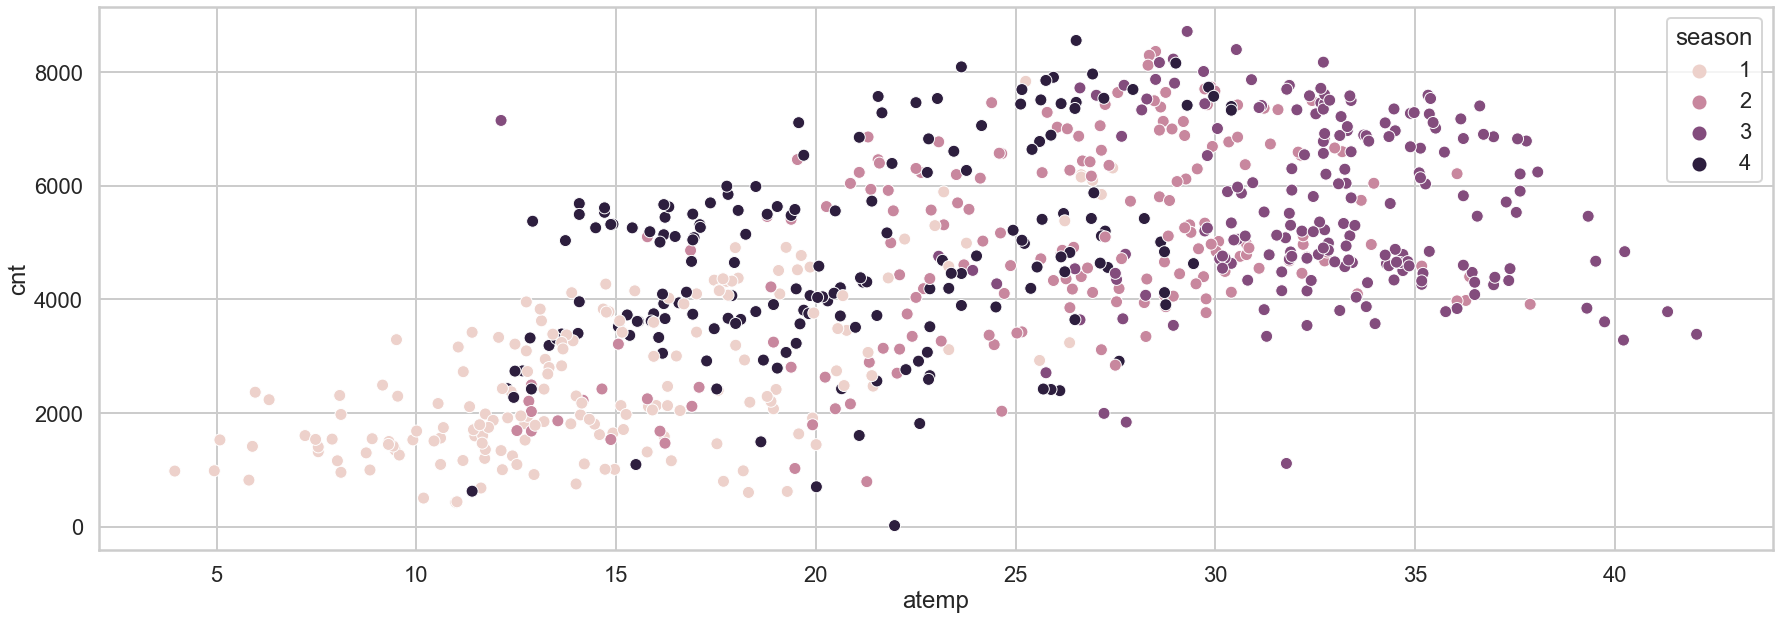

In [299]:
plt.figure(figsize=(30,10))
sns.scatterplot(data=bike_data,x='atemp',y='cnt', hue='season')

##### Observation
- Bike demand increases with `atemp`(strong relation) and `season`{from spring to summer to fall to winter)(light relation)

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

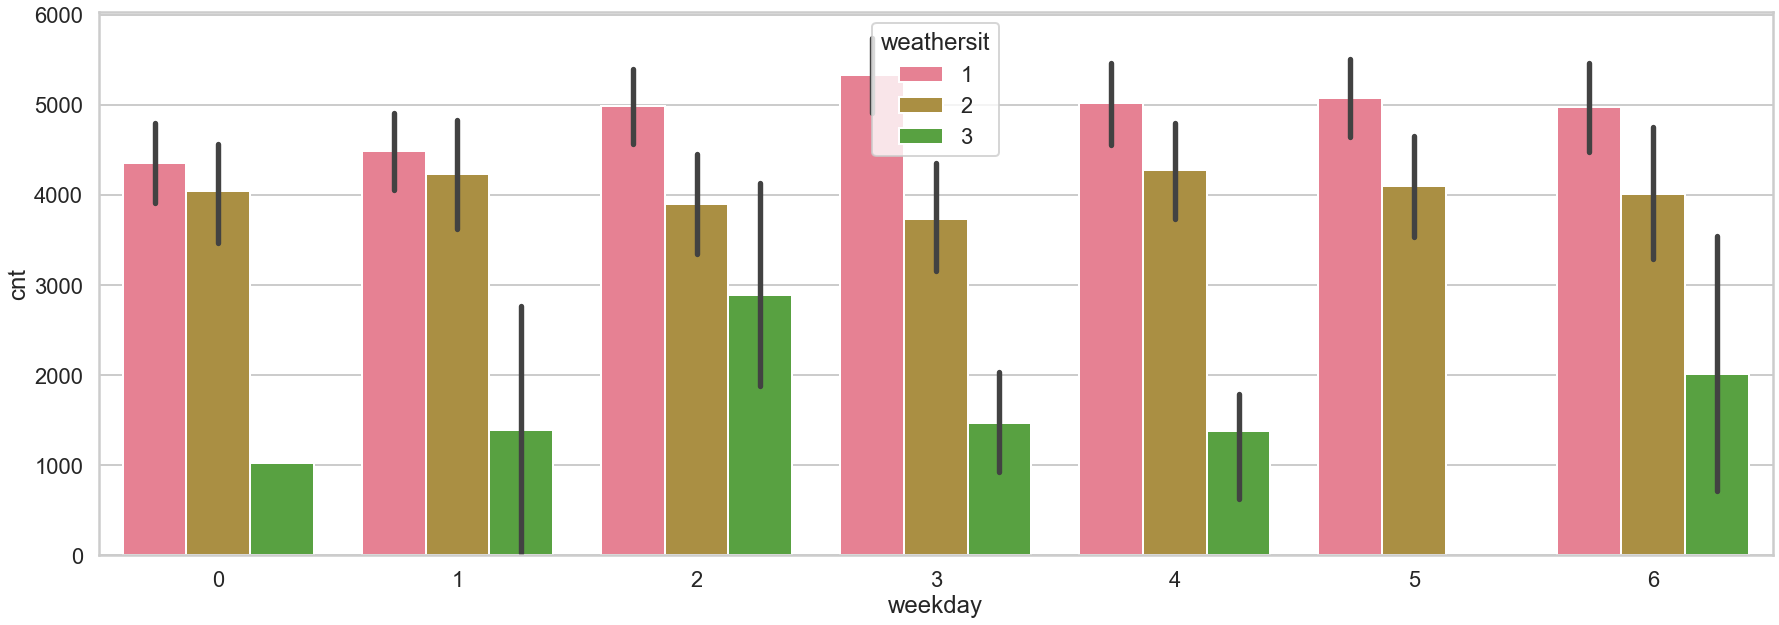

In [300]:
plt.figure(figsize=(30,10))
sns.barplot(data=bike_data,x='weekday',y='cnt', hue='weathersit')

##### Observation
- Bike demand increases with `weekday` and decreases with `weathersit`( as very few people goes outside in bad weather unless it is unavoidable)

### Relation of `cnt` with `mnth` and `workingday`

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

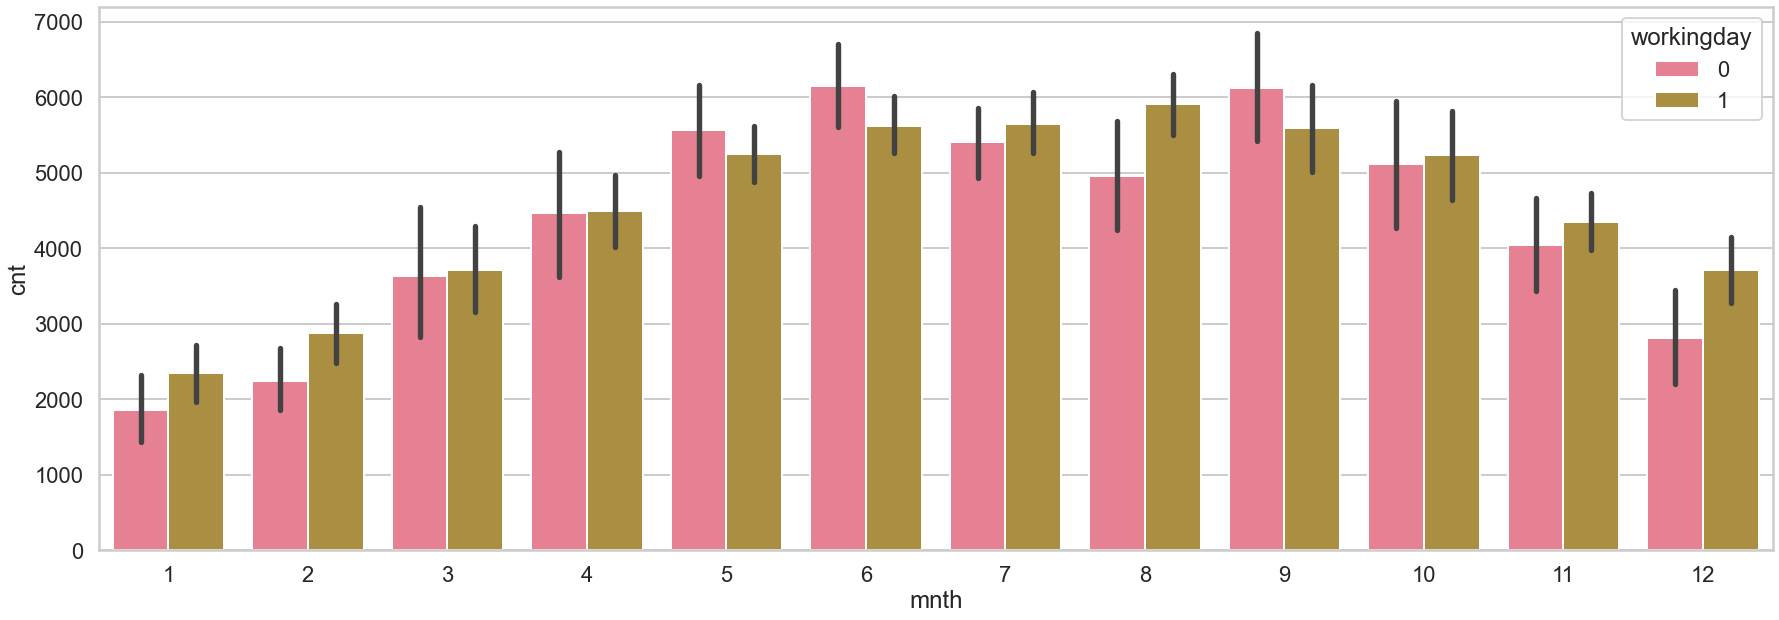

In [301]:
plt.figure(figsize=(30,10))
sns.barplot(data=bike_data,x='mnth',y='cnt', hue='workingday')

##### Observation
- Bike demand increases with `workingday` and  `mnth`(increases upto certain months and then decreases)

## Step 3: Data Preparation

### Categorical value encoding
As all categorical values are integer and they are already encoded from string to value, no further encoding to be done

In [302]:
bike_data.head()

instant  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0        1       1   0     1        0        6           0           2   
1        2       1   0     1        0        0           0           2   
2        3       1   0     1        0        1           1           1   
3        4       1   0     1        0        2           1           1   
4        5       1   0     1        0        3           1           1   

        temp     atemp      hum  windspeed  casual  registered     cnt  day  
0  14.110847  18.18125  80.5833  10.749882   331.0       654.0   985.0    1  
1  14.902598  17.68695  69.6087  16.652113   131.0       670.0   801.0    2  
2   8.050924   9.47025  43.7273  16.636703   120.0      1229.0  1349.0    3  
3   8.200000  10.60610  59.0435  10.739832   108.0      1454.0  1562.0    4  
4   9.305237  11.46350  43.6957  12.522300    82.0      1518.0  1600.0    5

### Dropping of variables
- As `registered` and `casual` are forming `cnt` variable, `registered` and `casual` to be dropped
- `instant` to be dropped as it is only used for counting of data
- As `atemp` is function of `temp` and `windspeed`, we were knowing that atleast `temp` has to be removed from data set

In [303]:
bike_data.drop(columns=['registered','casual','instant', 'temp'], axis=1, inplace=True)
bike_data.head()

season  yr  mnth  holiday  weekday  workingday  weathersit     atemp  \
0       1   0     1        0        6           0           2  18.18125   
1       1   0     1        0        0           0           2  17.68695   
2       1   0     1        0        1           1           1   9.47025   
3       1   0     1        0        2           1           1  10.60610   
4       1   0     1        0        3           1           1  11.46350   

       hum  windspeed     cnt  day  
0  80.5833  10.749882   985.0    1  
1  69.6087  16.652113   801.0    2  
2  43.7273  16.636703  1349.0    3  
3  59.0435  10.739832  1562.0    4  
4  43.6957  12.522300  1600.0    5

In [304]:
bike_data.describe()

season          yr        mnth     holiday     weekday  workingday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     2.498630    0.500000    6.526027    0.028767    2.997260    0.683562   
std      1.110184    0.500343    3.450215    0.167266    2.006161    0.465405   
min      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000    4.000000    0.000000    1.000000    0.000000   
50%      3.000000    0.500000    7.000000    0.000000    3.000000    1.000000   
75%      3.000000    1.000000   10.000000    0.000000    5.000000    1.000000   
max      4.000000    1.000000   12.000000    1.000000    6.000000    1.000000   

       weathersit       atemp         hum   windspeed          cnt         day  
count  730.000000  730.000000  730.000000  730.000000   730.000000  730.000000  
mean     1.394521   23.726322   62.795640   12.720661  4508.006849   15.720548  
std      0.544807    8.150308   14.126173    5.071566  1936.011647    8.802278  
min      1.000000    3.953480   20.515637    1.500244    22.000000    1.000000  
25%      1.000000   16.889713   52.000000    9.041650  3169.750000    8.000000  
50%      1.000000   24.368225   62.625000   12.125325  4548.500000   16.000000  
75%      2.000000   30.445775   72.989575   15.625589  5966.000000   23.000000  
max      3.000000   42.044800   97.250000   25.501498  8714.000000   31.000000

### Correlation

<AxesSubplot:>

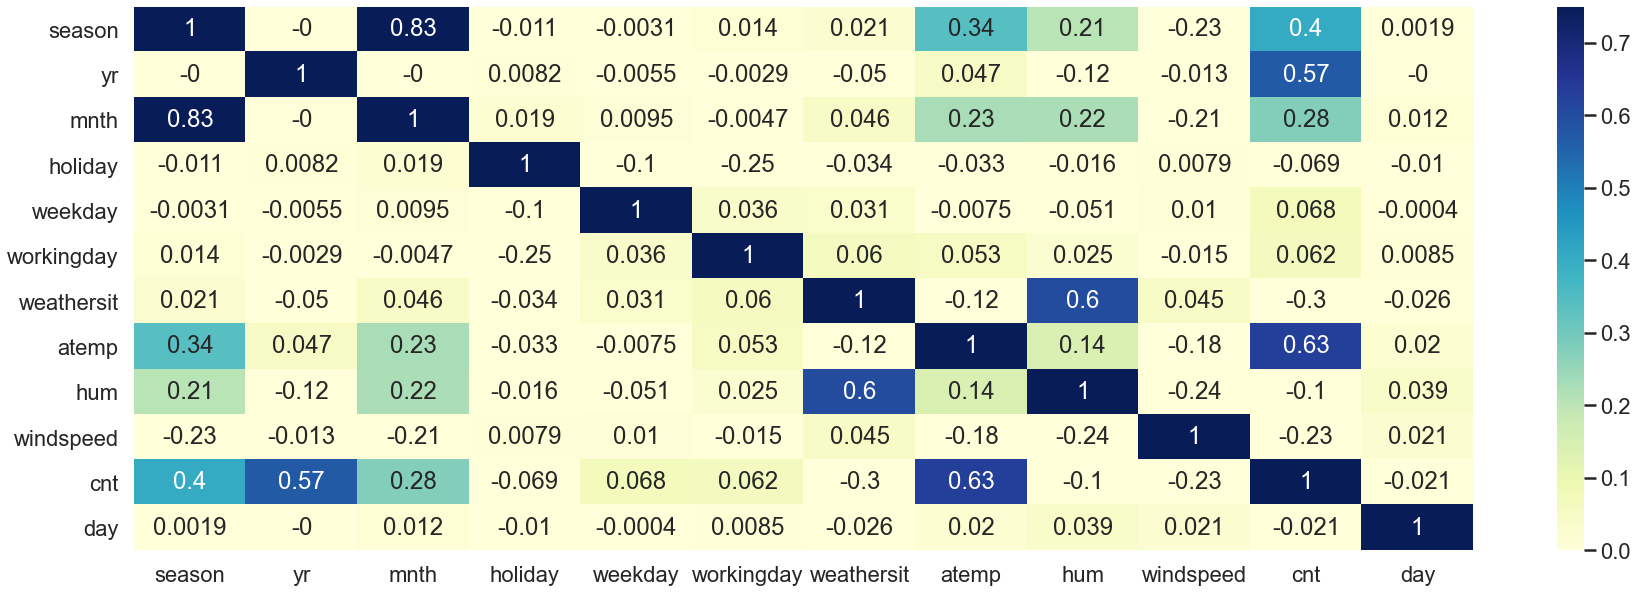

In [305]:
plt.figure(figsize=(30,10))
df1 = bike_data.corr().round(4)
sns.heatmap(df1, cmap='YlGnBu', annot=True, vmin=0, vmax=0.75)

##### Observation
- Bike demand is dependent on `temp`, `humidity`, `windspeed`, `yr`,`mnth` , `season` but we will see actual relationship as there might be multi-collianearity

## Step 4: Splitting the Data into Training and Testing Sets

In [306]:
np.random.seed(0) # for reproducible example
bike_data_train, bike_data_test = train_test_split(bike_data, train_size=0.7, random_state=100)

### Rescaling the Features 

As we know that, scaling doesn't impact  Linear Regression model. Here we can see that except for `cnt`, all the columns have small integer values. So it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale. As you know, there are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

This time, we will use MinMax scaling.

In [307]:
scaler = MinMaxScaler()
vars_to_be_scaled = ['cnt','hum','atemp','windspeed']
bike_data[vars_to_be_scaled] = scaler.fit_transform(bike_data[vars_to_be_scaled])

#### Dividing into X and Y sets for the model building

In [308]:
y_train = bike_data.pop('cnt')
X_train = bike_data

In [309]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   atemp       730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  day         730 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 62.9 KB


## Step 5: Building a linear model

Fit a regression line through the training data using `statsmodels`. Remember that in `statsmodels`, you need to explicitly fit a constant using `sm.add_constant(X)` because if we don't perform this step, `statsmodels` fits a regression line passing through the origin, by default.

Manual approach(without RFE)
- Start with all variables. Build model and look at summary. Drop variables based on p-value and VIF Value 

Autamatic approach( RFE)
- Start with approx 70% variables. Build model and look at summary. Drop variables based on p-value and VIF Value

We'll do both approach as number of variables are not quite high.

### Manual approach(without RFE)

In [310]:
# Add a const to X_train
X_train_1 = sm.add_constant(X_train)

### Model 1

In [311]:
# Running linear model
lm1 = sm.OLS(y_train,X_train_1).fit()

In [312]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     263.1
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          2.88e-243
Time:                        09:32:30   Log-Likelihood:                 650.69
No. Observations:                 730   AIC:                            -1277.
Df Residuals:                     718   BIC:                            -1222.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1889      0.023      8.323      0.000       0.144       0.233
season         0.0583      0.006      9.277      0.000       0.046       0.071
yr             0.2355      0.007     31.450      0.000       0.221       0.250
mnth          -0.0045      0.002     -2.285      0.023      -0.008      -0.001
holiday       -0.0585      0.023     -2.540      0.011      -0.104      -0.013
weekday        0.0081      0.002      4.317      0.000       0.004       0.012
workingday     0.0148      0.008      1.789      0.074      -0.001       0.031
weathersit    -0.0700      0.009     -7.674      0.000      -0.088      -0.052
atemp          0.5127      0.019     26.611      0.000       0.475       0.551
hum           -0.0886      0.028     -3.137      0.002      -0.144      -0.033
windspeed     -0.1002      0.019     -5.283      0.000      -0.137      -0.063
day           -0.0008      0.000     -1.868      0.062      -0.002    4.03e-05
==============================================================================
Omnibus:                       84.808   Durbin-Watson:                   0.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.884
Skew:                          -0.683   Prob(JB):                     1.06e-38
Kurtosis:                       4.970   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### VIF analysis

In [313]:
vif = pd.DataFrame()
X = X_train_1
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by='vif',ascending=False)
vif

features    vif
0        const  37.56
1       season   3.54
3         mnth   3.33
9          hum   1.97
7   weathersit   1.80
8        atemp   1.24
10   windspeed   1.17
4      holiday   1.08
6   workingday   1.08
2           yr   1.02
5      weekday   1.02
11         day   1.01

#### Order for dropping variables
1. High P Value & High VIF
2. High P Value & Low VIF
3. High VIF Value

#### Observation
- `workingday` is having high P-value, so drop it

### Model 2

Droppig `workingday` variable 

In [314]:
X_train_2 = X_train_1.drop('workingday', axis=1)

Building model without `workingday`

In [315]:
lm2 = sm.OLS(y_train,X_train_2).fit()

In [316]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     288.2
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          8.12e-244
Time:                        09:32:53   Log-Likelihood:                 649.07
No. Observations:                 730   AIC:                            -1276.
Df Residuals:                     719   BIC:                            -1226.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1979      0.022      8.929      0.000       0.154       0.241
season         0.0583      0.006      9.273      0.000       0.046       0.071
yr             0.2355      0.008     31.394      0.000       0.221       0.250
mnth          -0.0045      0.002     -2.303      0.022      -0.008      -0.001
holiday       -0.0687      0.022     -3.072      0.002      -0.113      -0.025
weekday        0.0081      0.002      4.323      0.000       0.004       0.012
weathersit    -0.0689      0.009     -7.561      0.000      -0.087      -0.051
atemp          0.5146      0.019     26.708      0.000       0.477       0.552
hum           -0.0901      0.028     -3.189      0.001      -0.146      -0.035
windspeed     -0.1008      0.019     -5.308      0.000      -0.138      -0.063
day           -0.0008      0.000     -1.848      0.065      -0.002    4.88e-05
==============================================================================
Omnibus:                       91.951   Durbin-Watson:                   0.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.445
Skew:                          -0.740   Prob(JB):                     3.27e-41
Kurtosis:                       4.985   Cond. No.                         167.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF analysis

In [317]:
vif = pd.DataFrame()
X = X_train_2
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by='vif',ascending=False)
vif

features    vif
0        const  35.71
1       season   3.54
3         mnth   3.33
8          hum   1.97
6   weathersit   1.79
7        atemp   1.23
9    windspeed   1.17
2           yr   1.02
4      holiday   1.02
5      weekday   1.02
10         day   1.01

#### Observation
- `day` is having high P-value, so drop it

### Model 3

Droppig `day` variable 

In [318]:
X_train_3 = X_train_2.drop('day', axis=1)

Building model without `day`

In [319]:
lm3 = sm.OLS(y_train,X_train_3).fit()

In [320]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     318.8
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          2.42e-244
Time:                        09:32:58   Log-Likelihood:                 647.34
No. Observations:                 730   AIC:                            -1275.
Df Residuals:                     720   BIC:                            -1229.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1871      0.021      8.738      0.000       0.145       0.229
season         0.0585      0.006      9.292      0.000       0.046       0.071
yr             0.2353      0.008     31.327      0.000       0.221       0.250
mnth          -0.0046      0.002     -2.328      0.020      -0.008      -0.001
holiday       -0.0682      0.022     -3.044      0.002      -0.112      -0.024
weekday        0.0081      0.002      4.305      0.000       0.004       0.012
weathersit    -0.0677      0.009     -7.437      0.000      -0.086      -0.050
atemp          0.5144      0.019     26.652      0.000       0.476       0.552
hum           -0.0942      0.028     -3.337      0.001      -0.150      -0.039
windspeed     -0.1025      0.019     -5.394      0.000      -0.140      -0.065
==============================================================================
Omnibus:                       98.692   Durbin-Watson:                   0.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.100
Skew:                          -0.775   Prob(JB):                     1.07e-45
Kurtosis:                       5.099   Cond. No.                         73.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF analysis

In [321]:
vif = pd.DataFrame()
X = X_train_3
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by='vif',ascending=False)
vif

features    vif
0       const  33.21
1      season   3.54
3        mnth   3.33
8         hum   1.95
6  weathersit   1.78
7       atemp   1.23
9   windspeed   1.17
2          yr   1.02
4     holiday   1.02
5     weekday   1.02

#### Observation
- All feautes are hacing acceptable P-value(<0.05). 
- `const` is having high VIF-value, so drop it

### Model 4

Droppig `const` variable 

In [322]:
X_train_4 = X_train_3.drop('const', axis=1)

Building model without `const`

In [323]:
lm4 = sm.OLS(y_train,X_train_4).fit()

In [324]:
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              2222.
Date:                Wed, 12 Jan 2022   Prob (F-statistic):                        0.00
Time:                        09:33:05   Log-Likelihood:                          610.55
No. Observations:                 730   AIC:                                     -1203.
Df Residuals:                     721   BIC:                                     -1162.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         0.0673      0.007     10.300      0.000       0.054       0.080
yr             0.2503      0.008     32.571      0.000       0.235       0.265
mnth          -0.0046      0.002     -2.216      0.027      -0.009      -0.001
holiday       -0.0524      0.023     -2.232      0.026      -0.098      -0.006
weekday        0.0127      0.002      6.741      0.000       0.009       0.016
weathersit    -0.0584      0.010     -6.147      0.000      -0.077      -0.040
atemp          0.5715      0.019     29.944      0.000       0.534       0.609
hum           -0.0047      0.028     -0.171      0.864      -0.059       0.050
windspeed     -0.0047      0.016     -0.291      0.771      -0.036       0.027
==============================================================================
Omnibus:                      141.180   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              335.138
Skew:                          -1.022   Prob(JB):                     1.68e-73
Kurtosis:                       5.615   Cond. No.                         65.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF analysis

In [325]:
vif = pd.DataFrame()
X = X_train_4
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by='vif',ascending=False)
vif

features    vif
0      season  20.94
7         hum  16.92
2        mnth  15.25
5  weathersit  13.28
6       atemp   7.53
8   windspeed   4.49
4     weekday   3.04
1          yr   1.94
3     holiday   1.04

#### Observation
- `hum` is having high VIF-value & high p-value, so drop it

### Model 5

Droppig `hum` variable 

In [326]:
X_train_5 = X_train_4.drop('hum', axis=1)

Building model without `hum`

In [327]:
lm5 = sm.OLS(y_train,X_train_5).fit()

In [328]:
lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              2504.
Date:                Wed, 12 Jan 2022   Prob (F-statistic):                        0.00
Time:                        09:33:13   Log-Likelihood:                          610.54
No. Observations:                 730   AIC:                                     -1205.
Df Residuals:                     722   BIC:                                     -1168.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         0.0673      0.007     10.310      0.000       0.054       0.080
yr             0.2504      0.008     32.648      0.000       0.235       0.265
mnth          -0.0046      0.002     -2.250      0.025      -0.009      -0.001
holiday       -0.0525      0.023     -2.242      0.025      -0.099      -0.007
weekday        0.0127      0.002      6.745      0.000       0.009       0.016
weathersit    -0.0596      0.006     -9.477      0.000      -0.072      -0.047
atemp          0.5703      0.018     32.129      0.000       0.535       0.605
windspeed     -0.0045      0.016     -0.277      0.782      -0.036       0.027
==============================================================================
Omnibus:                      140.481   Durbin-Watson:                   1.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              332.594
Skew:                          -1.018   Prob(JB):                     6.00e-73
Kurtosis:                       5.605   Cond. No.                         50.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF analysis

In [329]:
vif = pd.DataFrame()
X = X_train_5
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by='vif',ascending=False)
vif

features    vif
0      season  20.90
2        mnth  15.07
6       atemp   6.52
5  weathersit   5.83
7   windspeed   4.45
4     weekday   3.04
1          yr   1.93
3     holiday   1.04

#### Observation
- `windspeed` is having high p-value, so drop it

### Model 6

Droppig `windspeed` variable 

In [330]:
X_train_6 = X_train_5.drop('windspeed', axis=1)

Building model without `windspeed`

In [331]:
lm6 = sm.OLS(y_train,X_train_6).fit()

In [332]:
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              2865.
Date:                Wed, 12 Jan 2022   Prob (F-statistic):                        0.00
Time:                        09:33:15   Log-Likelihood:                          610.50
No. Observations:                 730   AIC:                                     -1207.
Df Residuals:                     723   BIC:                                     -1175.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         0.0672      0.007     10.313      0.000       0.054       0.080
yr             0.2502      0.008     32.885      0.000       0.235       0.265
mnth          -0.0046      0.002     -2.243      0.025      -0.009      -0.001
holiday       -0.0530      0.023     -2.266      0.024      -0.099      -0.007
weekday        0.0126      0.002      6.824      0.000       0.009       0.016
weathersit    -0.0604      0.006    -10.605      0.000      -0.072      -0.049
atemp          0.5694      0.017     32.605      0.000       0.535       0.604
==============================================================================
Omnibus:                      139.943   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              332.289
Skew:                          -1.014   Prob(JB):                     6.99e-73
Kurtosis:                       5.611   Cond. No.                         50.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF analysis

In [333]:
vif = pd.DataFrame()
X = X_train_6
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by='vif',ascending=False)
vif

features    vif
0      season  20.88
2        mnth  15.06
6       atemp   6.32
5  weathersit   4.78
4     weekday   2.92
1          yr   1.90
3     holiday   1.03

#### Observation
- `season` is having high VIF-value, so drop it

### Model 7

Droppig `season` variable 

In [334]:
X_train_7 = X_train_6.drop('season', axis=1)

Building model without `season`

In [335]:
lm7 = sm.OLS(y_train,X_train_7).fit()

In [336]:
lm7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                              2902.
Date:                Wed, 12 Jan 2022   Prob (F-statistic):                        0.00
Time:                        09:33:18   Log-Likelihood:                          560.41
No. Observations:                 730   AIC:                                     -1109.
Df Residuals:                     724   BIC:                                     -1081.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yr             0.2520      0.008     30.955      0.000       0.236       0.268
mnth           0.0131      0.001     10.845      0.000       0.011       0.015
holiday       -0.0586      0.025     -2.345      0.019      -0.108      -0.010
weekday        0.0132      0.002      6.678      0.000       0.009       0.017
weathersit    -0.0526      0.006     -8.701      0.000      -0.064      -0.041
atemp          0.6422      0.017     37.569      0.000       0.609       0.676
==============================================================================
Omnibus:                      127.484   Durbin-Watson:                   0.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.573
Skew:                          -1.023   Prob(JB):                     9.49e-53
Kurtosis:                       4.920   Cond. No.                         48.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF analysis

In [337]:
vif = pd.DataFrame()
X = X_train_7
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by='vif',ascending=False)
vif

features   vif
5       atemp  5.29
4  weathersit  4.69
1        mnth  4.54
3     weekday  2.92
0          yr  1.90
2     holiday  1.03

#### Observation
- `atemp` is having 5.29 VIF-value. As `atemp` shows effect of `temp` and `windspeed`, we don't want to drop it.

## Step 6: Residual Analysis
We want to check whether error are normalised or not which was the important assumption in linear regression

In [338]:
y_pred = lm7.predict(X_train_7)

Text(0.5, 0, 'Error')

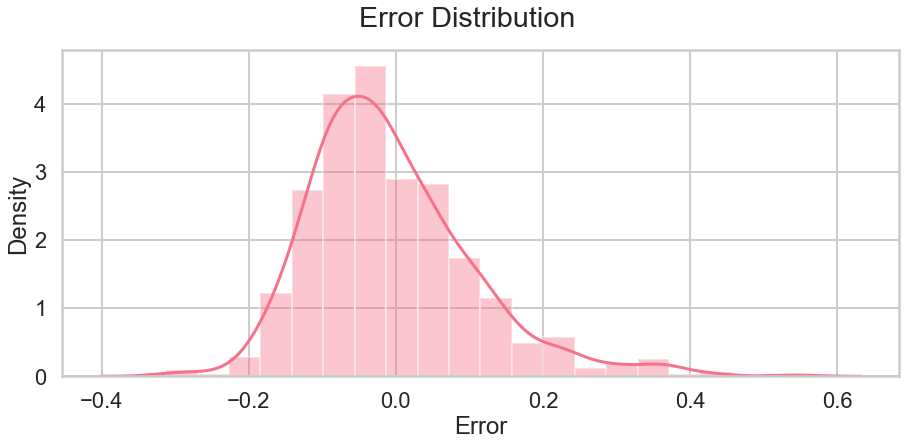

In [339]:
fig = plt.figure(figsize=(15,6))
sns.distplot(y_pred - y_train, bins = 20)
fig.suptitle('Error Distribution')
plt.xlabel('Error')

#### Observation
- Error terms follows normal distribution

#### Check for Homoscedasticity: Residual vs fitted

<AxesSubplot:>

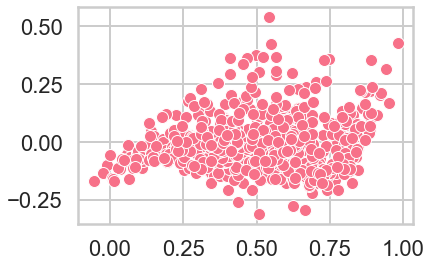

In [340]:
sns.scatterplot(y_pred, y_pred-y_train)

#### Observation
- Error terms are having almost constant deviation from zero line across dependendent variable.Although there are outlies of error terms, but most of the error terms follws constant deviation from zero line.

## Step 7: Making Predictions Using the Final Model

In [341]:
bike_data_test[vars_to_be_scaled] = scaler.transform(bike_data_test[vars_to_be_scaled])

#### Dividing X and y

In [342]:
y_test = bike_data_test.pop('cnt')
X_test = bike_data_test

#### Model prediction

In [343]:
# Using features which were used in final model i.e. model 5
X_test_1 = X_test[X_train_7.columns]

In [344]:
# Making predection
y_pred = lm7.predict(X_test_1)

## Step 8:  Model Evaluation

Text(0, 0.5, 'y_pred')

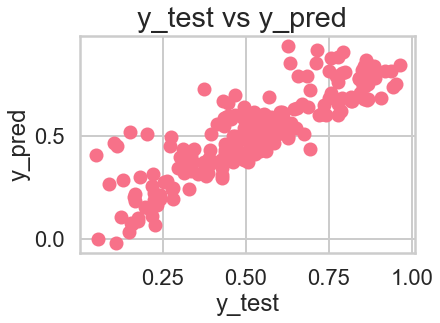

In [345]:
fig= plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred')
plt.xlabel('y_test')
plt.ylabel('y_pred')

#### RMSE

In [346]:
round(np.sqrt(mean_squared_error(y_test, y_pred)),4)

0.1142

#### R-squared on test set

In [347]:
r_square = r2_score(y_test,y_pred)
r_square

0.7273211582199735

#### Observation
- R-squared value for test data and train data is 0.727 and 0.96 respectively.

### We can see that the equation of our best fitted line is:

$bike demand = 0.6422  \times  atemp + 0.2520  \times  yr + 0.0131  \times  mnth - 0.0586 \times holiday  + 0.0132 \times weekday - 0.0526 \times weathersit$


### Autamatic approach(with RFE)

### RFE
Recursive feature elimination - If you want to start with 10 variables then RFE will give you 10 variables out of n independent variables. That doesn't mean this is stop and you are done with 10 variables, it is just start. We have to check for p-value & VIF after building model with 10 variables for any reduction of variables.

As there is total 11 variables, we will start with 9 variables(just start- we could have taken lower value as well)

As RFE requires estimator to be passed, we build linear regression model

In [348]:
# Add a const to X_train
X_train_rfe_1 = sm.add_constant(X_train)

In [349]:
lm = LinearRegression()
lm.fit(X_train_rfe_1,y_train)
rfe = RFE(estimator=lm, n_features_to_select=9)
rfe.fit(X_train_rfe_1, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=9)

In [350]:
list(zip(X_train_rfe_1.columns, rfe.support_, rfe.ranking_))

[('const', False, 4),
 ('season', True, 1),
 ('yr', True, 1),
 ('mnth', False, 2),
 ('holiday', True, 1),
 ('weekday', True, 1),
 ('workingday', True, 1),
 ('weathersit', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('day', False, 3)]

In [351]:
col = X_train_rfe_1.columns[rfe.support_]
X_train_rfe_1 = X_train_rfe_1[col]

### Model 1

In [352]:
# Running linear model
lm1 = sm.OLS(y_train,X_train_rfe_1).fit()

In [353]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              2248.
Date:                Wed, 12 Jan 2022   Prob (F-statistic):                        0.00
Time:                        09:34:19   Log-Likelihood:                          614.61
No. Observations:                 730   AIC:                                     -1211.
Df Residuals:                     721   BIC:                                     -1170.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         0.0546      0.004     14.826      0.000       0.047       0.062
yr             0.2486      0.008     32.493      0.000       0.234       0.264
holiday       -0.0356      0.024     -1.489      0.137      -0.083       0.011
weekday        0.0121      0.002      6.411      0.000       0.008       0.016
workingday     0.0304      0.008      3.609      0.000       0.014       0.047
weathersit    -0.0608      0.009     -6.408      0.000      -0.079      -0.042
atemp          0.5674      0.019     29.862      0.000       0.530       0.605
hum           -0.0171      0.027     -0.626      0.531      -0.071       0.037
windspeed     -0.0125      0.016     -0.773      0.440      -0.044       0.019
==============================================================================
Omnibus:                      121.010   Durbin-Watson:                   0.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              281.321
Skew:                          -0.892   Prob(JB):                     8.16e-62
Kurtosis:                       5.462   Cond. No.                         35.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF analysis

In [354]:
vif = pd.DataFrame()
X = X_train_rfe_1
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by='vif',ascending=False)
vif

features    vif
7         hum  16.77
5  weathersit  13.37
6       atemp   7.55
0      season   6.72
8   windspeed   4.59
4  workingday   3.22
3     weekday   3.05
1          yr   1.94
2     holiday   1.09

#### Observation
- `hum` is having high P-value and VIF, so drop it

### Model 2

Droppig `hum` variable 

In [355]:
X_train_rfe_2 = X_train_rfe_1.drop('hum', axis=1)

Building model without `hum`

In [356]:
lm2 = sm.OLS(y_train,X_train_rfe_2).fit()

In [357]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              2531.
Date:                Wed, 12 Jan 2022   Prob (F-statistic):                        0.00
Time:                        09:34:43   Log-Likelihood:                          614.41
No. Observations:                 730   AIC:                                     -1213.
Df Residuals:                     722   BIC:                                     -1176.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         0.0540      0.004     15.120      0.000       0.047       0.061
yr             0.2489      0.008     32.589      0.000       0.234       0.264
holiday       -0.0364      0.024     -1.526      0.127      -0.083       0.010
weekday        0.0120      0.002      6.409      0.000       0.008       0.016
workingday     0.0301      0.008      3.581      0.000       0.014       0.047
weathersit    -0.0652      0.006    -10.223      0.000      -0.078      -0.053
atemp          0.5633      0.018     31.589      0.000       0.528       0.598
windspeed     -0.0115      0.016     -0.713      0.476      -0.043       0.020
==============================================================================
Omnibus:                      118.770   Durbin-Watson:                   0.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.519
Skew:                          -0.881   Prob(JB):                     4.04e-60
Kurtosis:                       5.427   Cond. No.                         28.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF analysis

In [358]:
vif = pd.DataFrame()
X = X_train_rfe_2
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by='vif',ascending=False)
vif

features   vif
6       atemp  6.65
0      season  6.33
5  weathersit  6.05
7   windspeed  4.54
4  workingday  3.21
3     weekday  3.05
1          yr  1.94
2     holiday  1.09

#### Observation
- `windspeed` is having high P-value, so drop it

### Model 3

Droppig `windspeed` variable 

In [359]:
X_train_rfe_3 = X_train_rfe_2.drop('windspeed', axis=1)

Building model without `windspeed`

In [360]:
lm3 = sm.OLS(y_train,X_train_rfe_3).fit()

In [361]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              2895.
Date:                Wed, 12 Jan 2022   Prob (F-statistic):                        0.00
Time:                        09:34:53   Log-Likelihood:                          614.15
No. Observations:                 730   AIC:                                     -1214.
Df Residuals:                     723   BIC:                                     -1182.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         0.0540      0.004     15.127      0.000       0.047       0.061
yr             0.2483      0.008     32.734      0.000       0.233       0.263
holiday       -0.0380      0.024     -1.600      0.110      -0.085       0.009
weekday        0.0118      0.002      6.387      0.000       0.008       0.015
workingday     0.0292      0.008      3.516      0.000       0.013       0.046
weathersit    -0.0669      0.006    -11.365      0.000      -0.078      -0.055
atemp          0.5614      0.018     31.855      0.000       0.527       0.596
==============================================================================
Omnibus:                      117.868   Durbin-Watson:                   0.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.921
Skew:                          -0.871   Prob(JB):                     3.30e-60
Kurtosis:                       5.443   Cond. No.                         28.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF analysis

In [362]:
vif = pd.DataFrame()
X = X_train_rfe_3
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by='vif',ascending=False)
vif

features   vif
6       atemp  6.50
0      season  6.33
5  weathersit  5.16
4  workingday  3.14
3     weekday  2.95
1          yr  1.91
2     holiday  1.08

#### Observation
- `holiday` is having high P-value(>0.05), so drop it

### Model 4

Droppig `holiday` variable 

In [363]:
X_train_rfe_4 = X_train_rfe_3.drop('holiday', axis=1)

Building model without `holiday`

In [364]:
lm4 = sm.OLS(y_train,X_train_rfe_4).fit()

In [365]:
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              3369.
Date:                Wed, 12 Jan 2022   Prob (F-statistic):                        0.00
Time:                        09:35:03   Log-Likelihood:                          612.86
No. Observations:                 730   AIC:                                     -1214.
Df Residuals:                     724   BIC:                                     -1186.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         0.0537      0.004     15.047      0.000       0.047       0.061
yr             0.2477      0.008     32.660      0.000       0.233       0.263
weekday        0.0119      0.002      6.458      0.000       0.008       0.016
workingday     0.0321      0.008      3.941      0.000       0.016       0.048
weathersit    -0.0678      0.006    -11.567      0.000      -0.079      -0.056
atemp          0.5597      0.018     31.782      0.000       0.525       0.594
==============================================================================
Omnibus:                      116.347   Durbin-Watson:                   0.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              269.548
Skew:                          -0.862   Prob(JB):                     2.94e-59
Kurtosis:                       5.427   Cond. No.                         21.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF analysis

In [366]:
vif = pd.DataFrame()
X = X_train_rfe_4
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by='vif',ascending=False)
vif

features   vif
5       atemp  6.48
0      season  6.32
4  weathersit  5.11
3  workingday  3.00
2     weekday  2.95
1          yr  1.91

#### Observation
- All above six variables are having zero p-value which states that all these six variables are significant.
- `atemp` is having 6.48 VIF which is little higher than 5. Above model is built without `temp` and `windspeed` and if we drop `atemp` then effect of `temp` and `windspeed` may not be incorporated in model. 

## Step 6: Residual Analysis
We want to check whether error are normalised or not which was the important assumption in linear regression

In [368]:
y_pred = lm4.predict(X_train_rfe_4)

Text(0.5, 0, 'Error')

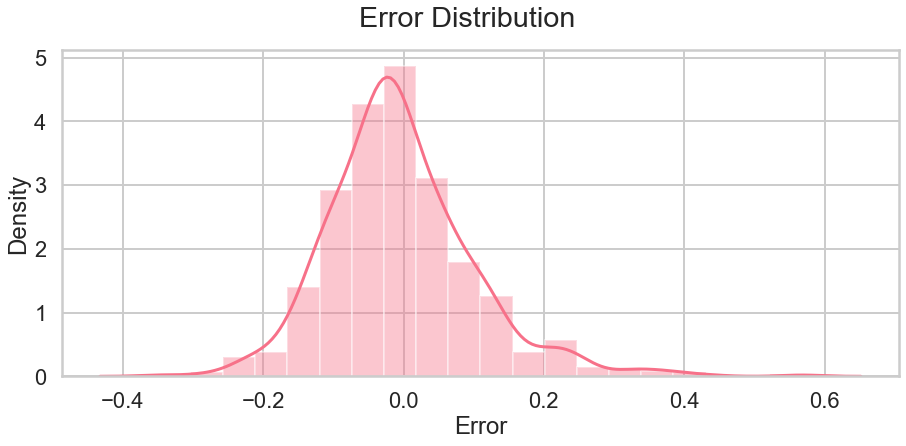

In [369]:
fig = plt.figure(figsize=(15,6))
sns.distplot(y_pred - y_train, bins = 20)
fig.suptitle('Error Distribution')
plt.xlabel('Error')

#### Observation
- Error terms follows normal distribution

#### Check for Homoscedasticity: Residual vs fitted

<AxesSubplot:>

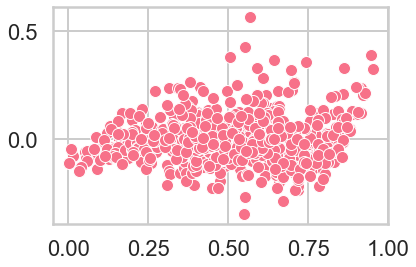

In [370]:
sns.scatterplot(y_pred, y_pred-y_train)

#### Observation
- Error terms are having almost constant deviation from zero line across dependendent variable.Although there are outlies of error terms, but most of the error terms follws constant deviation from zero line.

## Step 7: Making Predictions Using the Final Model

#### Model prediction

In [371]:
# Using features which were used in final model i.e. Model 4
X_test_2 = X_test[X_train_rfe_4.columns]

In [372]:
# Making predection
y_pred = lm4.predict(X_test_2)

## Step 8:  Model Evaluation

Text(0, 0.5, 'y_pred')

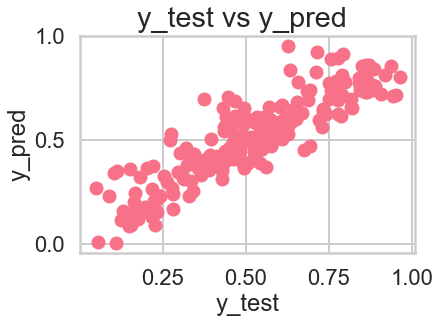

In [373]:
fig= plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred')
plt.xlabel('y_test')
plt.ylabel('y_pred')

#### RMSE

In [374]:
round(np.sqrt(mean_squared_error(y_test, y_pred)),4)

0.1024

#### R-squared on test set

In [375]:
r_square = r2_score(y_test,y_pred)
r_square

0.7806014627921625

#### Observation
- R-squared value for test data and train data is 0.781 and 0.965 respectively.

# Comparision of Automated(RFE) and Manual Approach for dropping feature

### Automated(RFE) approach:
#### Equation of  best fitted line 
$bikeDemand = 0.5597  \times  atemp + 0.2477  \times  yr + 0.0537 \times season + 0.0119 \times weekday + 0.0321 \times workingday - 0.0678 \times weathersit$

#### R-squared value : 
R-squared value for test data and train data is 0.781 and 0.965 respectively.


#### RMSE : 
EMSE is 0.1024



### Manual approach:
#### Equation of  best fitted line 
$bikeDemand = 0.6422  \times  atemp + 0.2520  \times  yr + 0.0131  \times  mnth - 0.0586 \times holiday  + 0.0132 \times weekday - 0.0526 \times weathersit$

#### R-squared value : 
R-squared value for test data and train data is 0.727 and 0.96 respectively.

#### RMSE : 
EMSE is 0.1142



# Conclusion:
- As R-squared value for test data is high and RMSE is low in RFE(automatic) approach for removing variables, we will consider that model-4 as final
- All dependent variables in equation are in-line with results/observations of EDA.